## 1. Import packages

Remember to add the parent path of Coadding to your system, I use the command `sys.path.append()` for this purpose.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from penquins import Kowalski

base = '/data/deepnika'

import sys
sys.path.append(base)


from Coadding.keypairs import get_keypairs
from Coadding.setup import copy_final_forcePSF, download_marshal_data, yes_no
from Coadding.reconstruct_data import generate_final_fpsf_file, generate_final_marshal_file, analyze_marshal,  \
                        generate_baseline_file, generate_combined_file, calculate_mag
from Coadding.query_kowalski import query_kowal, get_kdata
from Coadding.baseline import compute_offset, compute_baseline, apply_shift
from Coadding.coadd import coadd_rem_outliers, coadd
from Coadding.plots import  plotlc, jdref_plot, plot_mag, plot_fil


name = 'ZTF18achdidy'
targetdir = base + '/Coadding/SLSNe-coadd/' + name + '/'
targetdir

'/data/deepnika/Coadding/SLSNe-coadd/ZTF18achdidy/'

### Copy Forced Photometry results

In [2]:
copy_final_forcePSF(name, targetdir, base)
mtb = generate_final_fpsf_file(name, targetdir)

/data/deepnika/Coadding/reconstruct_data.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['filter'][ig] = 'g'
/data/deepnika/Coadding/reconstruct_data.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['filter'][ir] = 'r'
/data/deepnika/Coadding/reconstruct_data.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['filter'][ii] = 'i'
/data/deepnika/Coadding/reconstruct_data.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

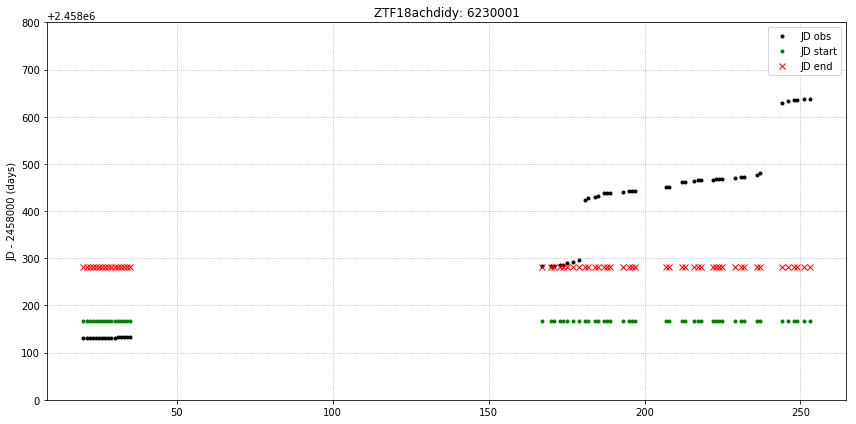

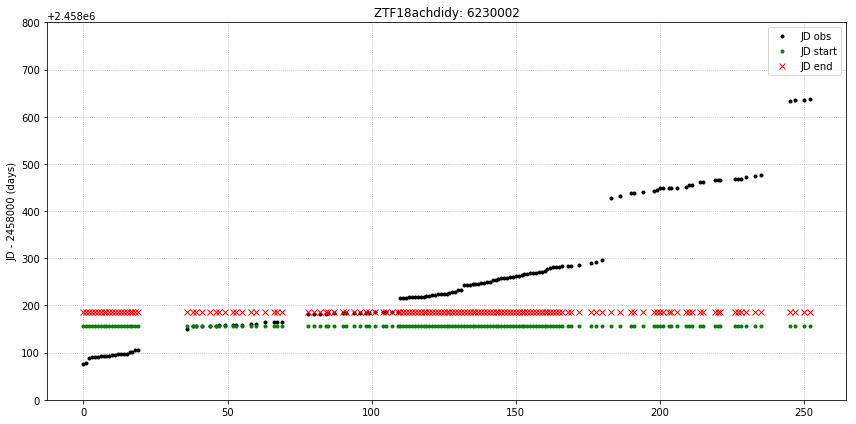

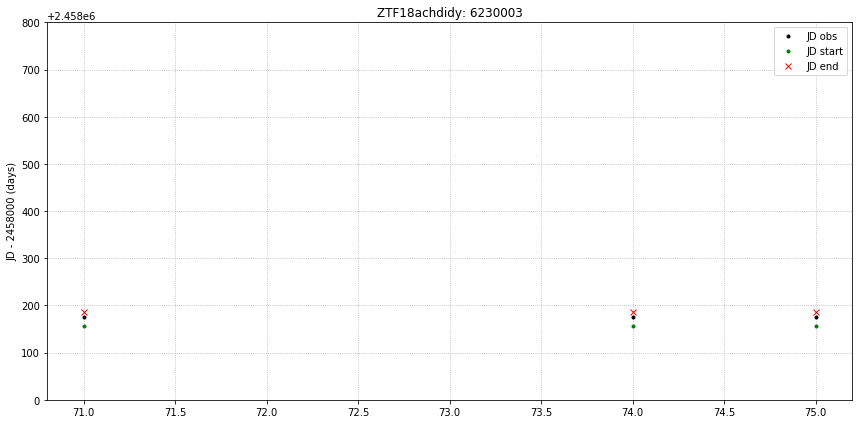

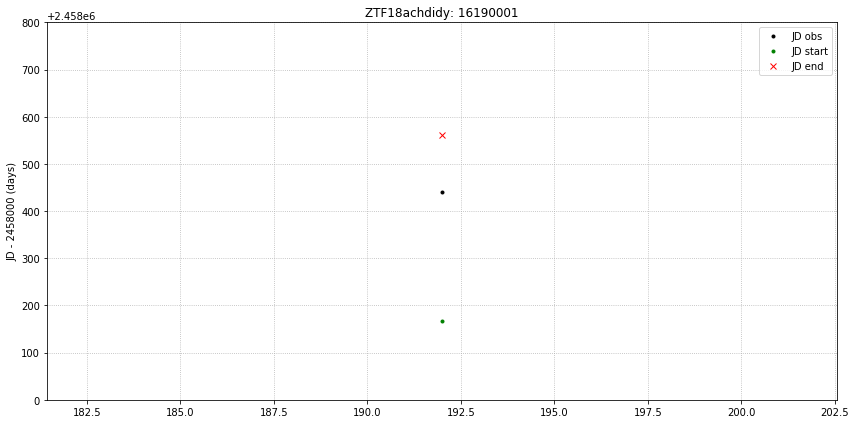

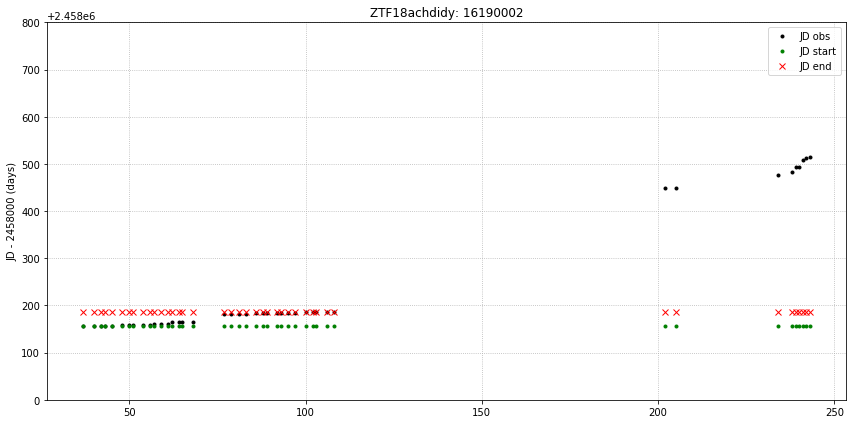

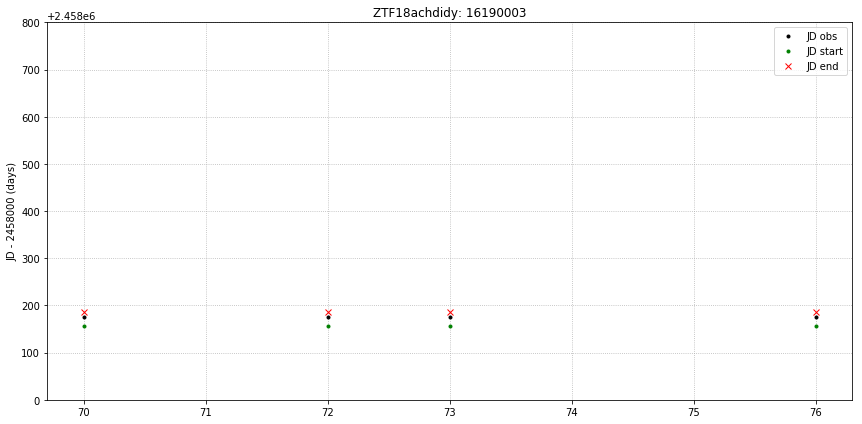

In [3]:
jdref_plot(targetdir, name, mtb, 0, 800)

### Plot Forced Photometry results

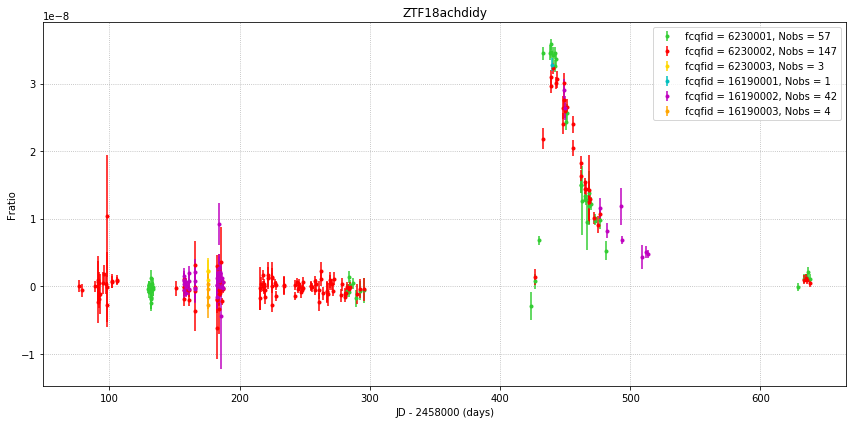

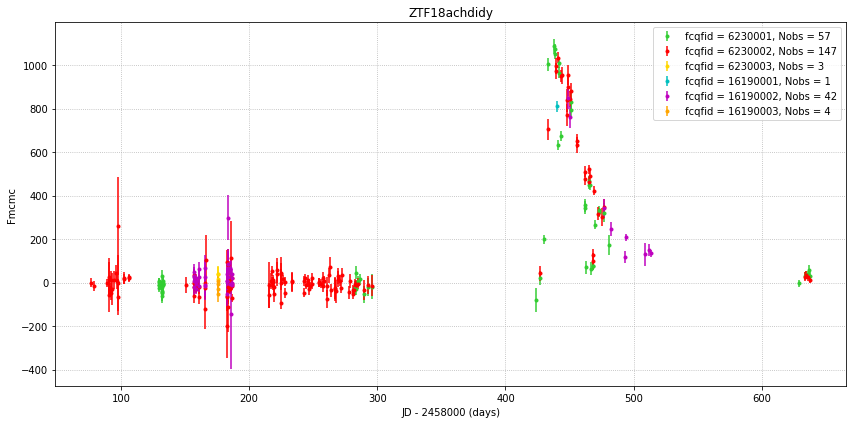

In [4]:
plotlc(mtb, 'Fratio', name, targetdir)
plotlc(mtb, 'Fmcmc', name, targetdir)

## 2. Download Marshal data

In [5]:
download_marshal_data(name, targetdir)
marshal = generate_final_marshal_file(name, targetdir)

/data/deepnika/Coadding/reconstruct_data.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  marshal['Fratio'][~pos] = -1 * marshal['Fratio'][~pos]
/data/deepnika/Coadding/reconstruct_data.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  marshal['fcqfid'][ig] = 1
/data/deepnika/Coadding/reconstruct_data.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  marshal['fcqfid'][ir] = 2
/data/deepnika/Coadding/reconstruct_data.py:178: SettingWithCopyWarning: 
A value is trying to be 

#### Analyze Marshal data

In [13]:
# marshal1 contains extra (pID == 1) rows
# jd contains JDs of the extra data

jd1, marshal1 = analyze_marshal(marshal, mtb)
baseline_shift = False

In [14]:
marshal1

,date,jdobs,filter,seeing,absmag,mag,emag,limmag,Fmcmc,Fmcmc_unc,...,upperlim,programid,instrument,source,refsys,issub,isdiffpos,offset,f0,ef0
18,2019 Jan 03,2.458487e+06,g,0.0,-18.72,20.25,0.24,20.61,0.0,0.0,...,True,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
23,2019 Jan 08,2.458492e+06,g,0.0,-18.49,20.47,0.26,20.42,0.0,0.0,...,True,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
24,2019 Jan 08,2.458492e+06,r,0.0,-18.46,20.51,0.32,20.12,0.0,0.0,...,True,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
29,2019 Jan 11,2.458495e+06,r,0.0,-18.39,20.57,0.17,20.80,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0


## 3. Run the following cells if baseline shift is needed for any filter

### 3a. Query Kowalski

In [15]:
DEFAULT_AUTHs = get_keypairs()
DEFAULT_AUTH_kowalski = DEFAULT_AUTHs[1]

def query_kowal(name, lowjd, upjd):
    k = Kowalski(username=DEFAULT_AUTH_kowalski[0], password=DEFAULT_AUTH_kowalski[1], verbose=False)
    qu = {"query_type": "general_search", 
          "query": "db['ZTF_alerts'].find({'objectId': {'$eq': '%s'}, 'candidate.jd': {'$gt': '%d'}, 'candidate.jd': {'$lt': '%d'}}, {'candidate.jd': 1, 'candidate.fid': 1,   \
          'candidate.programid': 1, 'candidate.field': 1, 'candidate.magzpsci': 1, 'candidate.magzpsciunc': 1,})"%(name, lowjd, upjd)}

    r = k.query(query=qu)
    
    return r

In [18]:
def get_r(jd1):
    for i in range(len(jd1)):
        l = jd1[i] - 0.5
        u = jd1[i] + 0.5
        r = query_kowal(name, l, u)
        if 'result_data' in list(r.keys()):
            rdata = r['result_data']
            rrdata = rdata['query_result']  
            n = len(rrdata)
            print(rrdata)

    return r

In [19]:
r = get_r(jd1)

[]
[]
[]
[]


In [ ]:
def get_kdata(targetdir, name, r):
    if 'result_data' in list(r.keys()):
        rdata = r['result_data']
        rrdata = rdata['query_result']  
        n = len(rrdata)

        jd = []
        fid = []
        programid = []
        fieldid = []
        mag = []
        magzp = []
        magzp_unc = []

        for i in range(n):
            if rrdata[i]['candidate']['programid'] == 1:
                jd.append(rrdata[i]['candidate']['jd'])
#                 fid.append(rrdata[i]['candidate']['fid'])
#                 programid.append(rrdata[i]['candidate']['programid'])
#                 fieldid.append(rrdata[i]['candidate']['field'])
#                 mag.append(rrdata[i]['candidate']['magpsf'])
#                 magzp.append(rrdata[i]['candidate']['magzpsci'])
#                 magzp_unc.append(rrdata[i]['candidate']['magzpsciunc'])

        jd = np.array(jd)
#         fid = np.array(fid)
#         programid = np.array(programid)
#         fieldid = np.array(fieldid)
#         mag = np.array(mag)
#         magzp = np.array(magzp)
#         magzp_unc = np.array(magzp_unc)

#         k_data = Table([jd, fid, programid, fieldid, mag, magzp, magzp_unc], \
#                        names = ['jdobs', 'fid', 'programid', 'fieldid', 'mag', 'magzp', 'magzp_unc'])
        k_data = Table([jd], names = ['jdobs'])
        kdata = k_data.to_pandas()
#         kdata.to_csv(targetdir + 'data/kowalski_data_' + name + '.csv', index = False, encoding = 'utf8')
    
    
    else:
        print(('Kowalski query is not succesful for %s'%name))

    kdata = kdata.drop_duplicates()
    kdata.sort_values(['jdobs'], inplace = True)
    p = kdata.shape
    
    
    if 'result_data' in list(r.keys()):
        rdata = r['result_data']
        rrdata = rdata['query_result']  
        n = len(rrdata)

        jd = []
#         fid = []
#         programid = []
#         fieldid = []
#         mag = []
#         magzp = []
#         magzp_unc = []

#         for i in range(n):
#             if rrdata[i]['prv_candidates'] != None:
#                 m = len(rrdata[i]['prv_candidates'])
#                 for j in range(m):
#                     if 'magzpsci' in list(rrdata[i]['prv_candidates'][j].keys()):
#                         if rrdata[i]['prv_candidates'][j]['magpsf'] != None:
#                             if rrdata[i]['prv_candidates'][j]['programid'] == 1:
#                                 jd.append (rrdata[i]['prv_candidates'][j]['jd'])
#                                 fid.append (rrdata[i]['prv_candidates'][j]['fid'])
#                                 programid.append (rrdata[i]['prv_candidates'][j]['programid'])
#                                 fieldid.append (rrdata[i]['prv_candidates'][j]['field'])
#                                 mag.append (rrdata[i]['prv_candidates'][j]['magpsf'])
#                                 magzp.append (rrdata[i]['prv_candidates'][j]['magzpsci'])
#                                 magzp_unc.append (rrdata[i]['prv_candidates'][j]['magzpsciunc'])
                                
                                
        for i in range(n):
            if rrdata[i]['prv_candidates'] != None:
                m = len(rrdata[i]['prv_candidates'])
                for j in range(m):
                    if rrdata[i]['prv_candidates'][j]['programid'] == 1:
                        jd.append (rrdata[i]['prv_candidates'][j]['jd'])

        jd = np.array(jd)
#         fid = np.array(fid)
#         programid = np.array(programid)
#         fieldid = np.array(fieldid)
#         mag = np.array(mag)
#         magzp = np.array(magzp)
#         magzp_unc = np.array(magzp_unc)

#         k_data = Table([jd, fid, programid, fieldid, mag, magzp, magzp_unc], \
#                        names = ['jdobs', 'fid', 'programid', 'fieldid', 'mag', 'magzp', 'magzp_unc'])
        k_data = Table([jd], names = ['jdobs'])
        kdata1 = k_data.to_pandas()
        kdata1.to_csv(targetdir + 'data/kowalski_data1_' + name + '.csv', index = False, encoding = 'utf8')

    
    else:
        print(('Kowalski query is not succesful for %s'%name))

    kdata1 = kdata1.drop_duplicates()
    kdata1.sort_values(['jdobs'], inplace = True)
    q = kdata1.shape
    
    
    kdata = kdata.append(kdata1)
    kdata = kdata.drop_duplicates()
#     kdata.sort_values(['jdobs'], inplace = True)
    
#     return p, q, kdata

In [2]:
# p, q, kdata = get_kdata(targetdir, name, r)
# print(p, q)

In [3]:
# marshal.sort_values(['jdobs'], inplace = True)
# ii = marshal.programid == 1
# marshal[ii]

In [4]:
# kdata

In [14]:
# marshal[ii]

In [20]:
# #This is done because of the way JD is stored on Marshal and Kowalski is different.

# kdata['jdobs'] = np.trunc(kdata['jdobs']*1000) / 1000
# marshal['jdobs'] = np.trunc(marshal['jdobs']*1000)/1000

In [21]:
# iq = np.in1d(kdata['jdobs'].values, marshal['jdobs'][ii].values)
# kdata = kdata[iq]

In [6]:
# 

In [5]:
# kdata

In [7]:
# for i in range(kdata.shape[0]):
#     if kdata['jdobs'].iloc[i] == marshal['jdobs'][ii].iloc[i]:
#         print('hi')
#     else:
#         print(i)
#         print (kdata['jdobs'].iloc[i])
#         marshal['jdobs'][ii].iloc[i]


## Run this cell to apply baseline shift on Forced Photometry data

### 3b. Baseline shift

In [5]:
baseline = mtb

n = baseline.shape[0]
outlier = [False for i in range(n)]
baseline.insert(23, 'outlier', outlier)

chisq = np.zeros(n)
baseline.insert(24, 'chisq', chisq)

baseline.to_csv(targetdir + 'data/baseline_' + name + '.csv', index = False, encoding = 'utf8')

In [6]:
baseline

,date,jdobs,filter,seeing,absmag,mag,emag,limmag,Fmcmc,Fmcmc_unc,...,instrument,source,refsys,issub,isdiffpos,offset,outlier,chisq,f0,ef0
0,2017-11-19,2.458077e+06,r,3.782,0.0,0.0,0.0,0.0,-0.005533,21.517858,...,P48+ZTF,IPAC,None,True,False,0.0,False,0.0,2.511886e+10,3.990891e+05
1,2017-11-21,2.458079e+06,r,2.386,0.0,0.0,0.0,0.0,-15.497413,23.421229,...,P48+ZTF,IPAC,None,True,False,0.0,False,0.0,2.511886e+10,4.402214e+05
2,2017-12-01,2.458089e+06,r,1.966,0.0,0.0,0.0,0.0,-0.855620,19.428320,...,P48+ZTF,IPAC,None,True,False,0.0,False,0.0,2.511886e+10,4.327764e+05
3,2017-12-03,2.458091e+06,r,1.835,0.0,0.0,0.0,0.0,16.104062,77.782973,...,P48+ZTF,IPAC,None,True,True,0.0,False,0.0,2.511886e+10,1.619207e+06
4,2017-12-03,2.458091e+06,r,1.690,0.0,0.0,0.0,0.0,24.622913,86.514792,...,P48+ZTF,IPAC,None,True,True,0.0,False,0.0,2.511886e+10,1.872928e+06
5,2017-12-03,2.458091e+06,r,1.861,0.0,0.0,0.0,0.0,-58.899469,78.127057,...,P48+ZTF,IPAC,None,True,False,0.0,False,0.0,2.511886e+10,1.272277e+06
6,2017-12-04,2.458092e+06,r,2.027,0.0,0.0,0.0,0.0,-32.476867,30.829223,...,P48+ZTF,IPAC,None,True,False,0.0,False,0.0,2.511886e+10,4.760534e+05
7,2017-12-04,2.458092e+06,r,2.024,0.0,0.0,0.0,0.0,-48.905543,32.104385,...,P48+ZTF,IPAC,None,True,False,0.0,False,0.0,2.511886e+10,6.352013e+05
8,2017-12-04,2.458092e+06,r,2.473,0.0,0.0,0.0,0.0,12.486271,39.672314,...,P48+ZTF,IPAC,None,True,True,0.0,False,0.0,2.511886e+10,5.531935e+05
9,2017-12-05,2.458093e+06,r,4.576,0.0,0.0,0.0,0.0,-29.754032,73.953959,...,P48+ZTF,IPAC,None,True,False,0.0,False,0.0,2.511886e+10,1.045374e+06


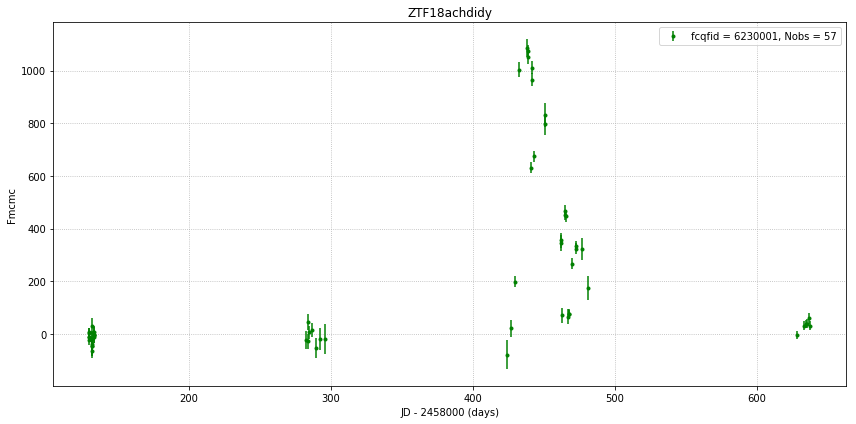

Compute Offset?
y
Please enter startjd-2458000:
600
Please enter endjd-2458000:
700


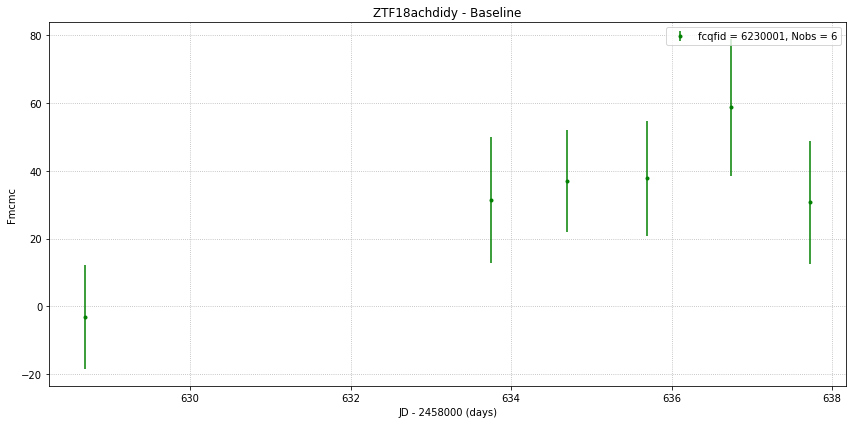

Remove Outliers?
y
Standard Deviation:  18.617254286887956 about Fmcmc =  29.750415371076272


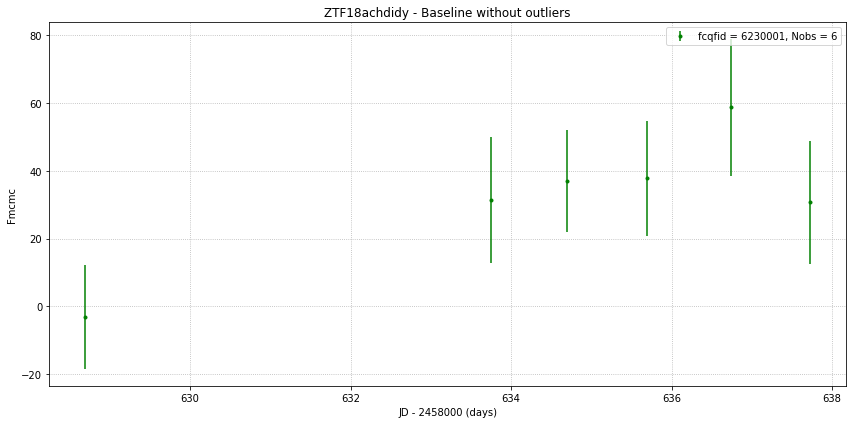

Offset:  29.750415371076272
Chisq:  1.424124207723652


/data/deepnika/Coadding/baseline.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['offset'][ix] = offset
/data/deepnika/Coadding/baseline.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['chisq'][ix] = chisq


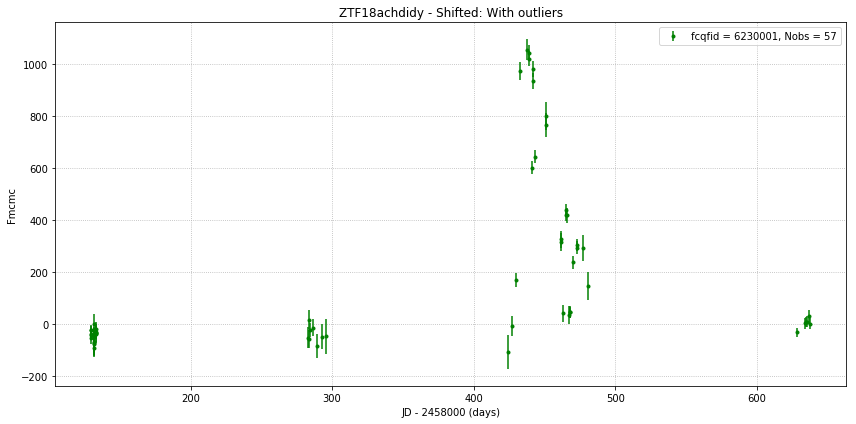

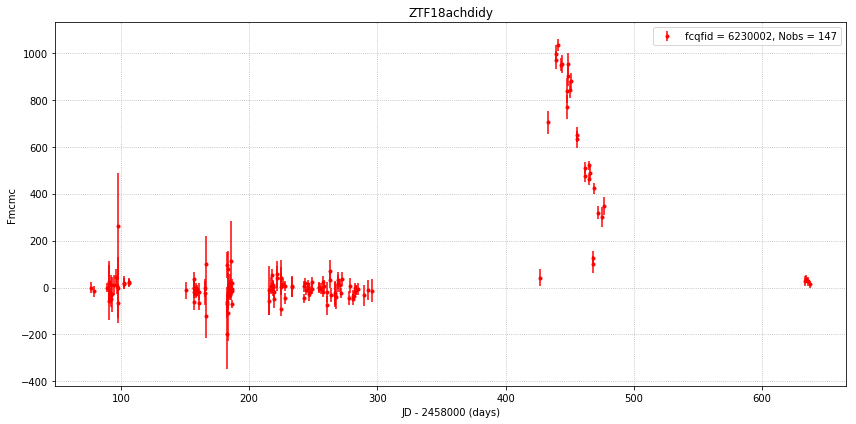

Compute Offset?
y
Please enter startjd-2458000:
600
Please enter endjd-2458000:
700


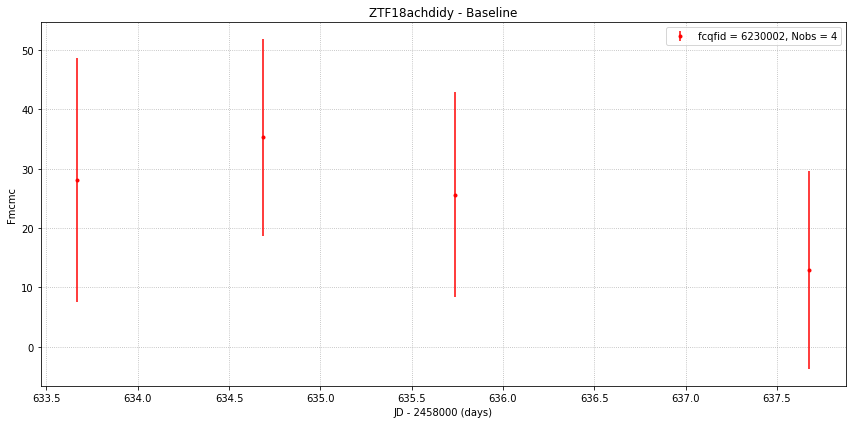

Remove Outliers?
y
Standard Deviation:  8.486765087426646 about Fmcmc =  25.30413752721995


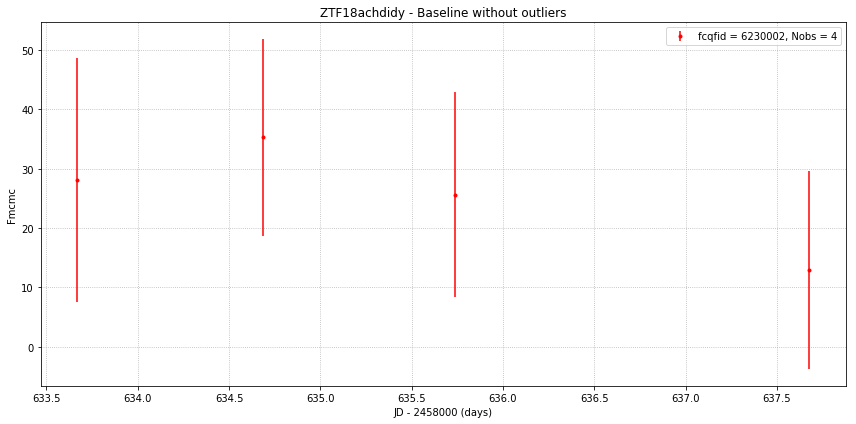

Offset:  25.30413752721995
Chisq:  0.3104724495965419


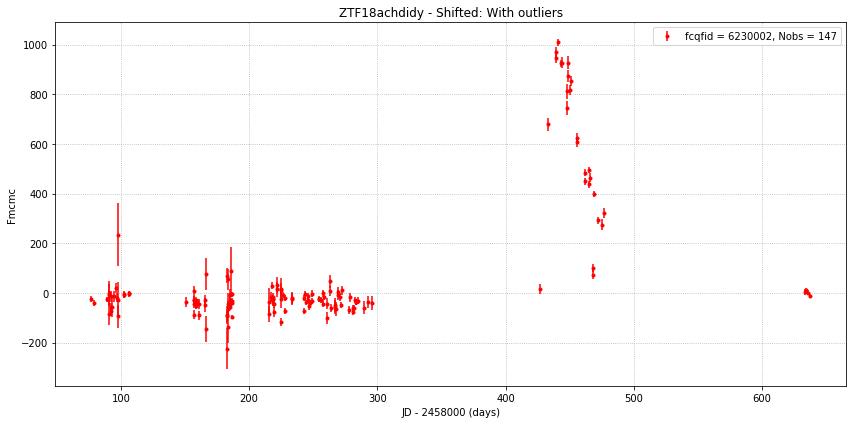

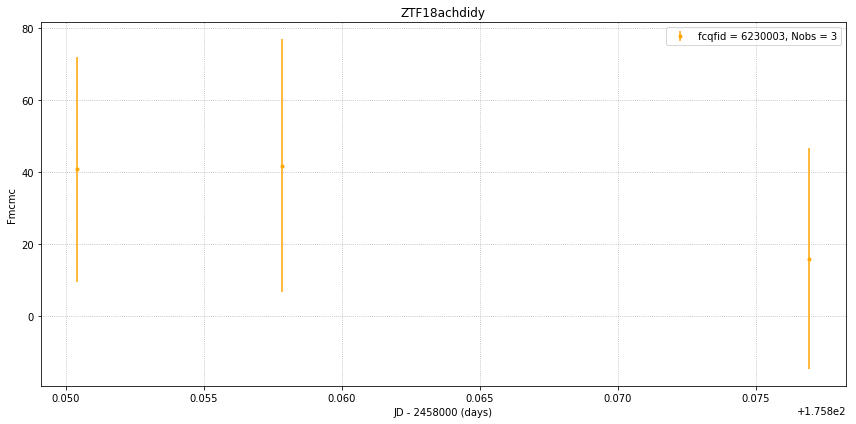

Compute Offset?
n


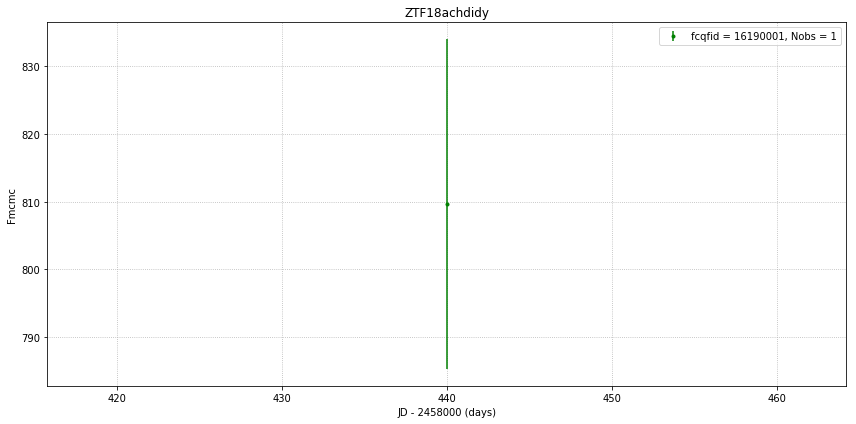

Compute Offset?
n


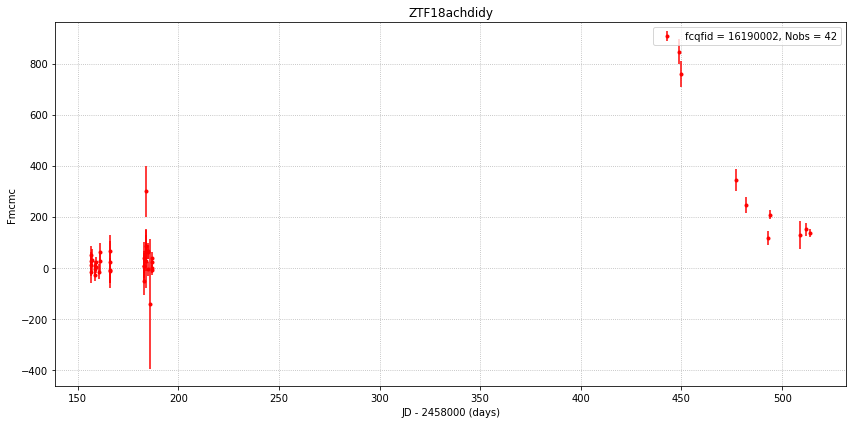

Compute Offset?
n


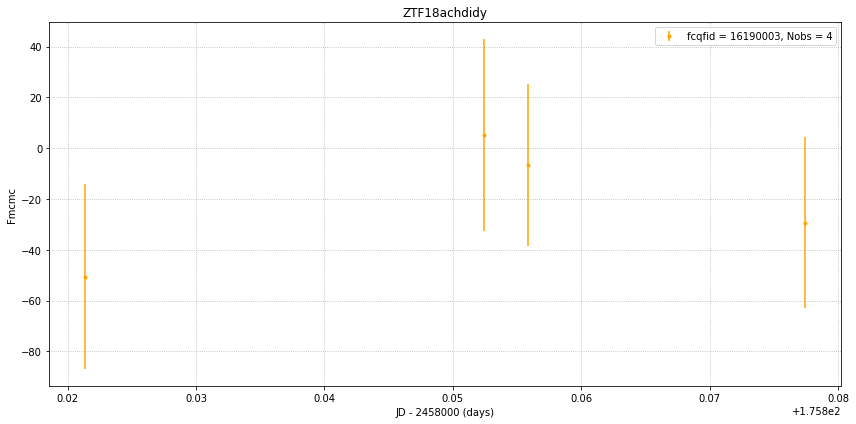

Compute Offset?
n


In [7]:
baseline = pd.read_csv(targetdir + 'data/baseline_' + name + '.csv')
compute_baseline(name, targetdir, baseline)

###### Checkpoint

In [8]:
baseline1 = pd.read_csv(targetdir + 'data/baseline1_' + name + '.csv')
pd.set_option('display.max_rows', None)
baseline1

,date,jdobs,filter,seeing,absmag,mag,emag,limmag,Fmcmc,Fmcmc_unc,...,instrument,source,refsys,issub,isdiffpos,offset,outlier,chisq,f0,ef0
0,2017-11-19,2.458077e+06,r,3.782,0.0,0.0,0.0,0.0,-0.005533,21.517858,...,P48+ZTF,IPAC,None,True,False,25.304138,False,0.310472,2.511886e+10,3.990891e+05
1,2017-11-21,2.458079e+06,r,2.386,0.0,0.0,0.0,0.0,-15.497413,23.421229,...,P48+ZTF,IPAC,None,True,False,25.304138,False,0.310472,2.511886e+10,4.402214e+05
2,2017-12-01,2.458089e+06,r,1.966,0.0,0.0,0.0,0.0,-0.855620,19.428320,...,P48+ZTF,IPAC,None,True,False,25.304138,False,0.310472,2.511886e+10,4.327764e+05
3,2017-12-03,2.458091e+06,r,1.835,0.0,0.0,0.0,0.0,16.104062,77.782973,...,P48+ZTF,IPAC,None,True,True,25.304138,False,0.310472,2.511886e+10,1.619207e+06
4,2017-12-03,2.458091e+06,r,1.690,0.0,0.0,0.0,0.0,24.622913,86.514792,...,P48+ZTF,IPAC,None,True,True,25.304138,False,0.310472,2.511886e+10,1.872928e+06
5,2017-12-03,2.458091e+06,r,1.861,0.0,0.0,0.0,0.0,-58.899469,78.127057,...,P48+ZTF,IPAC,None,True,False,25.304138,False,0.310472,2.511886e+10,1.272277e+06
6,2017-12-04,2.458092e+06,r,2.027,0.0,0.0,0.0,0.0,-32.476867,30.829223,...,P48+ZTF,IPAC,None,True,False,25.304138,False,0.310472,2.511886e+10,4.760534e+05
7,2017-12-04,2.458092e+06,r,2.024,0.0,0.0,0.0,0.0,-48.905543,32.104385,...,P48+ZTF,IPAC,None,True,False,25.304138,False,0.310472,2.511886e+10,6.352013e+05
8,2017-12-04,2.458092e+06,r,2.473,0.0,0.0,0.0,0.0,12.486271,39.672314,...,P48+ZTF,IPAC,None,True,True,25.304138,False,0.310472,2.511886e+10,5.531935e+05
9,2017-12-05,2.458093e+06,r,4.576,0.0,0.0,0.0,0.0,-29.754032,73.953959,...,P48+ZTF,IPAC,None,True,False,25.304138,False,0.310472,2.511886e+10,1.045374e+06


In [9]:
fcqfid = baseline1['fcqfid']
offset = baseline1['offset']
chisq = baseline1['chisq']

l = list(zip(fcqfid, offset, chisq))

rdata = pd.DataFrame(l, columns = ['fcqfid', 'offset', 'chisq'])
rdata = rdata.drop_duplicates()
rdata

,fcqfid,offset,chisq
0,6230002.0,25.304138,0.310472
20,6230001.0,29.750415,1.424124
37,16190002.0,0.000000,0.000000
70,16190003.0,0.000000,0.000000
71,6230003.0,0.000000,0.000000
192,16190001.0,0.000000,0.000000


In [10]:
fcqfs = np.unique(rdata['fcqfid'].values)
fcqfs

array([ 6230001.,  6230002.,  6230003., 16190001., 16190002., 16190003.])

In [11]:
for ffid in fcqfs:
    baseline1 = apply_shift(targetdir, name, baseline1, ffid)

29.75041537107627
1.4241242077236518
25.30413752721995
0.3104724495965419


/data/deepnika/Coadding/baseline.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb1['Fmcmc'] = mtb1['Fmcmc'] - mtb1['offset']
/data/deepnika/Coadding/baseline.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb1['Fmcmc_unc'] = mtb1['Fmcmc_unc'] * np.sqrt(chi)
/data/deepnika/Coadding/baseline.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [12]:
baseline1.to_csv(targetdir + 'data/baseline2_' + name + '.csv', index = False, encoding = 'utf8')

###### Checkpoint

In [13]:
baseline2 = pd.read_csv(targetdir + 'data/baseline2_' + name + '.csv')
baseline2

,date,jdobs,filter,seeing,absmag,mag,emag,limmag,Fmcmc,Fmcmc_unc,...,instrument,source,refsys,issub,isdiffpos,offset,outlier,chisq,f0,ef0
0,2017-11-19,2.458077e+06,r,3.782,0.0,0.0,0.0,0.0,-25.309670,21.517858,...,P48+ZTF,IPAC,None,True,False,0.0,False,1.0,2.511886e+10,3.990891e+05
1,2017-11-21,2.458079e+06,r,2.386,0.0,0.0,0.0,0.0,-40.801551,23.421229,...,P48+ZTF,IPAC,None,True,False,0.0,False,1.0,2.511886e+10,4.402214e+05
2,2017-12-01,2.458089e+06,r,1.966,0.0,0.0,0.0,0.0,-26.159757,19.428320,...,P48+ZTF,IPAC,None,True,False,0.0,False,1.0,2.511886e+10,4.327764e+05
3,2017-12-03,2.458091e+06,r,1.835,0.0,0.0,0.0,0.0,-9.200076,77.782973,...,P48+ZTF,IPAC,None,True,True,0.0,False,1.0,2.511886e+10,1.619207e+06
4,2017-12-03,2.458091e+06,r,1.690,0.0,0.0,0.0,0.0,-0.681224,86.514792,...,P48+ZTF,IPAC,None,True,True,0.0,False,1.0,2.511886e+10,1.872928e+06
5,2017-12-03,2.458091e+06,r,1.861,0.0,0.0,0.0,0.0,-84.203606,78.127057,...,P48+ZTF,IPAC,None,True,False,0.0,False,1.0,2.511886e+10,1.272277e+06
6,2017-12-04,2.458092e+06,r,2.027,0.0,0.0,0.0,0.0,-57.781005,30.829223,...,P48+ZTF,IPAC,None,True,False,0.0,False,1.0,2.511886e+10,4.760534e+05
7,2017-12-04,2.458092e+06,r,2.024,0.0,0.0,0.0,0.0,-74.209680,32.104385,...,P48+ZTF,IPAC,None,True,False,0.0,False,1.0,2.511886e+10,6.352013e+05
8,2017-12-04,2.458092e+06,r,2.473,0.0,0.0,0.0,0.0,-12.817867,39.672314,...,P48+ZTF,IPAC,None,True,True,0.0,False,1.0,2.511886e+10,5.531935e+05
9,2017-12-05,2.458093e+06,r,4.576,0.0,0.0,0.0,0.0,-55.058169,73.953959,...,P48+ZTF,IPAC,None,True,False,0.0,False,1.0,2.511886e+10,1.045374e+06


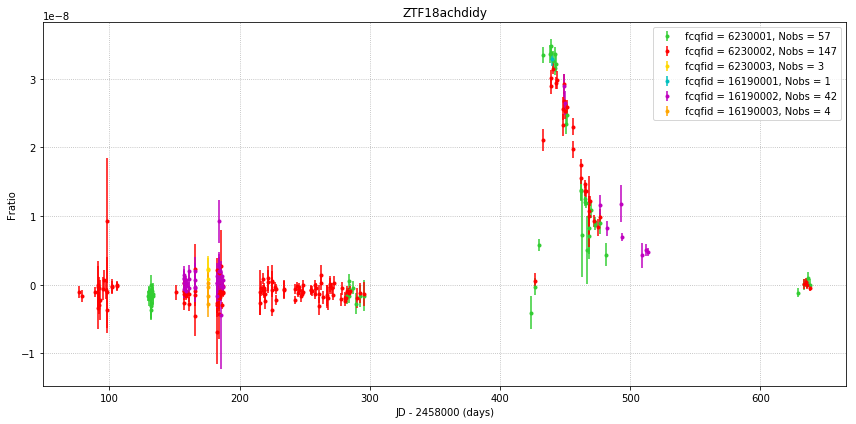

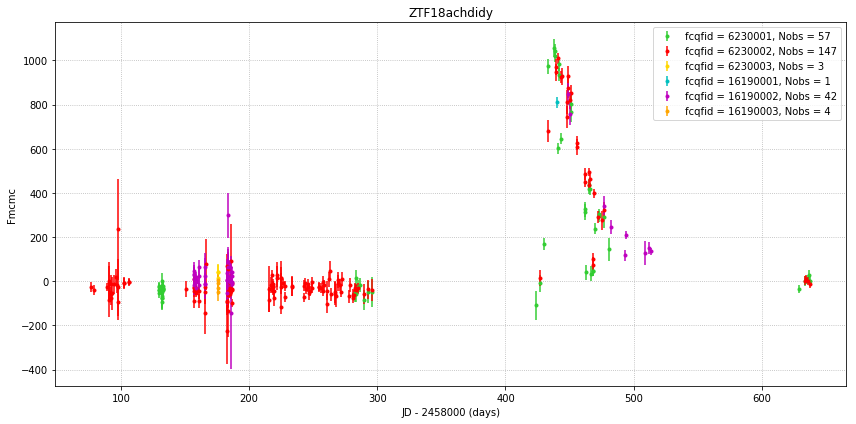

In [14]:
plotlc(baseline2, 'Fratio', name, targetdir)
plotlc(baseline2, 'Fmcmc', name, targetdir)

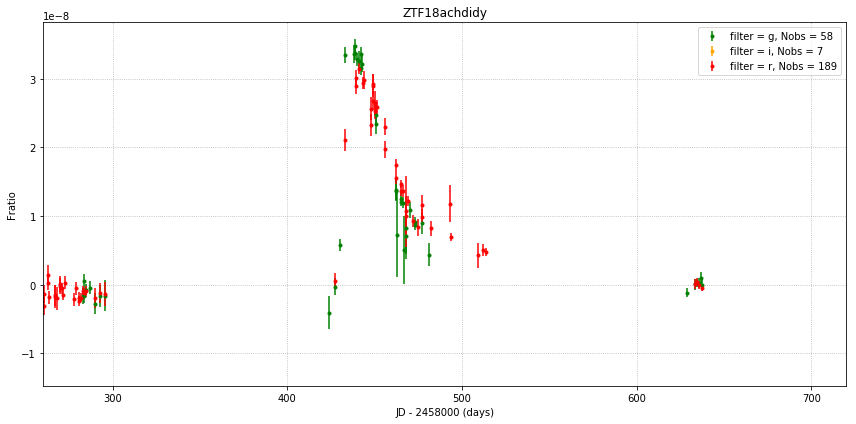

In [15]:
plot_fil(baseline2, name, targetdir, 260, 720)

#### Remove outliers from baseline (optional)

In [16]:
baseline2 = baseline2[baseline2.outlier == False]

In [17]:
## Remove offset, outlier, chisq, f0, ef0

baseline2.drop(baseline.iloc[:,[22, 23, 24, 25, 26]], axis = 1, inplace = True)

In [18]:
baseline_shift = True
baseline2.to_csv(targetdir + 'data/baseline3_' + name + '.csv', index = False, encoding = 'utf8')

## 4. Coadd

###### Checkpoint

In [19]:
if baseline_shift == False:
    baseline = generate_baseline_file(name, targetdir, mtb, marshal)
if baseline_shift == True:
    baseline = pd.read_csv(targetdir + 'data/baseline3_' + name + '.csv')

In [20]:
n = baseline.shape[0]
SNR = np.zeros(n)
baseline.insert(22, 'SNR', SNR)
coa = np.zeros(n)
baseline.insert(23, 'coa', coa)
baseline['SNR'] = baseline['Fratio']/baseline['Fratio_unc']
baseline.to_csv(targetdir + 'data/baseline3_' + name + '.csv', index = False, encoding = 'utf8')
pd.set_option('display.max_rows', None)
baseline

,date,jdobs,filter,seeing,absmag,mag,emag,limmag,Fmcmc,Fmcmc_unc,...,fcqfid,upperlim,programid,instrument,source,refsys,issub,isdiffpos,SNR,coa
0,2017-11-19,2.458077e+06,r,3.782,0.0,0.0,0.0,0.0,-25.309670,21.517858,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.176217,0.0
1,2017-11-21,2.458079e+06,r,2.386,0.0,0.0,0.0,0.0,-40.801551,23.421229,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.742076,0.0
2,2017-12-01,2.458089e+06,r,1.966,0.0,0.0,0.0,0.0,-26.159757,19.428320,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.346475,0.0
3,2017-12-03,2.458091e+06,r,1.835,0.0,0.0,0.0,0.0,-9.200076,77.782973,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,True,-0.118279,0.0
4,2017-12-03,2.458091e+06,r,1.690,0.0,0.0,0.0,0.0,-0.681224,86.514792,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,True,-0.007874,0.0
5,2017-12-03,2.458091e+06,r,1.861,0.0,0.0,0.0,0.0,-84.203606,78.127057,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.077778,0.0
6,2017-12-04,2.458092e+06,r,2.027,0.0,0.0,0.0,0.0,-57.781005,30.829223,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.874228,0.0
7,2017-12-04,2.458092e+06,r,2.024,0.0,0.0,0.0,0.0,-74.209680,32.104385,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-2.311512,0.0
8,2017-12-04,2.458092e+06,r,2.473,0.0,0.0,0.0,0.0,-12.817867,39.672314,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,True,-0.323093,0.0
9,2017-12-05,2.458093e+06,r,4.576,0.0,0.0,0.0,0.0,-55.058169,73.953959,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-0.744493,0.0


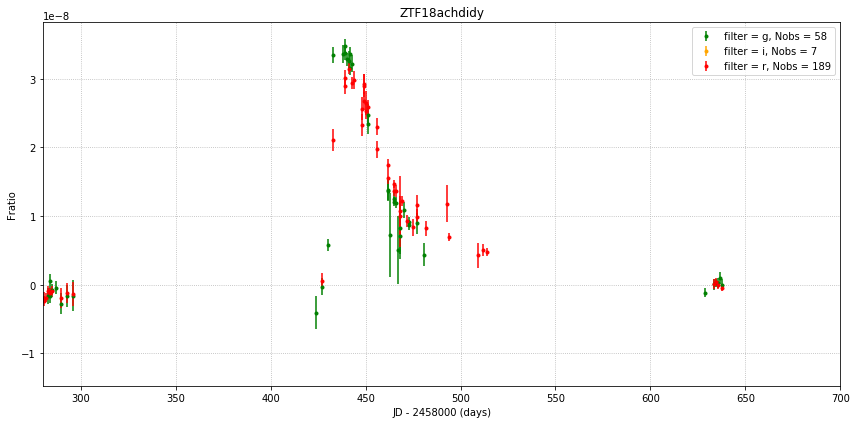

In [21]:
plot_fil(baseline, name, targetdir, 280, 700)

In [22]:
t = baseline['SNR'] < 5
baseline1 = baseline[t]

In [23]:
baseline1

,date,jdobs,filter,seeing,absmag,mag,emag,limmag,Fmcmc,Fmcmc_unc,...,fcqfid,upperlim,programid,instrument,source,refsys,issub,isdiffpos,SNR,coa
0,2017-11-19,2.458077e+06,r,3.782,0.0,0.0,0.0,0.0,-25.309670,21.517858,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.176217,0.0
1,2017-11-21,2.458079e+06,r,2.386,0.0,0.0,0.0,0.0,-40.801551,23.421229,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.742076,0.0
2,2017-12-01,2.458089e+06,r,1.966,0.0,0.0,0.0,0.0,-26.159757,19.428320,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.346475,0.0
3,2017-12-03,2.458091e+06,r,1.835,0.0,0.0,0.0,0.0,-9.200076,77.782973,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,True,-0.118279,0.0
4,2017-12-03,2.458091e+06,r,1.690,0.0,0.0,0.0,0.0,-0.681224,86.514792,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,True,-0.007874,0.0
5,2017-12-03,2.458091e+06,r,1.861,0.0,0.0,0.0,0.0,-84.203606,78.127057,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.077778,0.0
6,2017-12-04,2.458092e+06,r,2.027,0.0,0.0,0.0,0.0,-57.781005,30.829223,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-1.874228,0.0
7,2017-12-04,2.458092e+06,r,2.024,0.0,0.0,0.0,0.0,-74.209680,32.104385,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-2.311512,0.0
8,2017-12-04,2.458092e+06,r,2.473,0.0,0.0,0.0,0.0,-12.817867,39.672314,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,True,-0.323093,0.0
9,2017-12-05,2.458093e+06,r,4.576,0.0,0.0,0.0,0.0,-55.058169,73.953959,...,6230002.0,True,0.0,P48+ZTF,IPAC,None,True,False,-0.744493,0.0


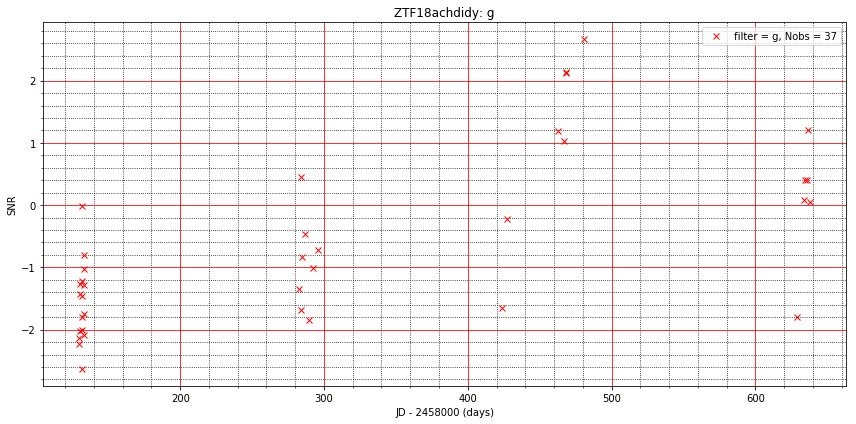

Coadd?
y
Please enter startjd-2458000:
460
Please enter endjd-2458000:
470
Found a real detection.

Fratio =  7.13087203150629e-09 

Fratio_unc =  2.1182885806894637e-09 

SNR =  3.3663364361740187 



/data/deepnika/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Coadd?
n


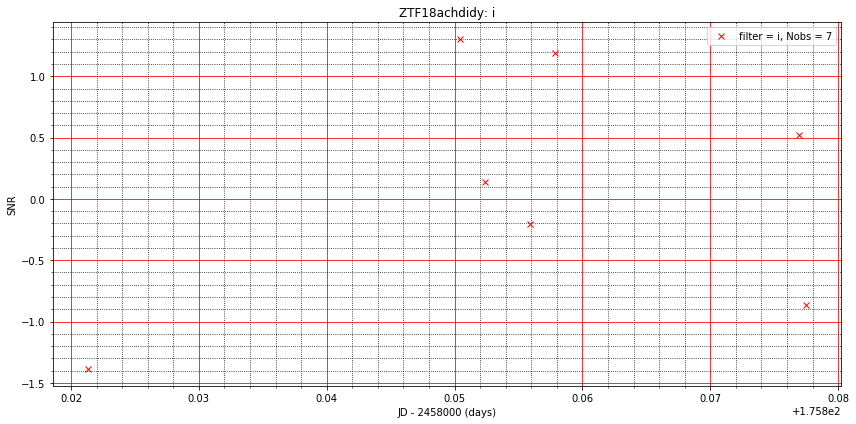

Coadd?
n


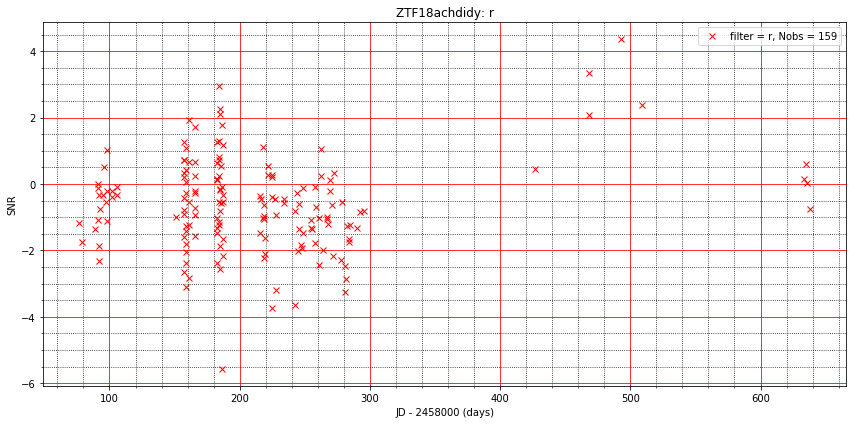

Coadd?
y
Please enter startjd-2458000:
630
Please enter endjd-2458000:
640
Not a detection.

SNR =  -0.011022881809718598 

Coadd?
n


In [24]:
baseline1 = coadd(targetdir, name, baseline1)

In [25]:
baseline.update(baseline1)
baseline.to_csv(targetdir + 'data/baseline3_' + name + '.csv', index = False, encoding = 'utf8')

###### Checkpoint

In [32]:
baseline1 = pd.read_csv(targetdir + 'data/baseline3_' + name + '.csv')
baseline1 = baseline1.drop(baseline1.iloc[:, [0, 3, 4, 8, 9, 12, 13, 14]], axis = 1)

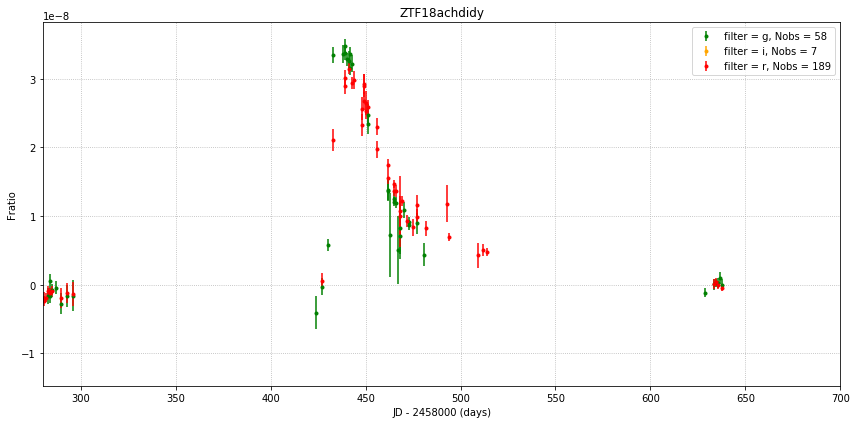

In [33]:
plot_fil(baseline1, name, targetdir, 280, 700)

###### Checkpoint

In [34]:
ix = baseline1['coa'] == 1
if np.sum(ix) > 0:
    coadd1 = pd.read_csv(targetdir + 'data/coadd_' + name + '.csv')
    n = coadd1.shape[0]
    for i in range(n):
        baseline1 = baseline1.append({'jdobs': coadd1['jdobs'][i], 'filter': coadd1['filter'][i], 'mag' : 0, 'emag' : 0 ,
                                      'limmag' : 0, 'Fratio' : coadd1['Fratio'][i], 'Fratio_unc' : coadd1['Fratio_unc'][i],
                                      'upperlim' : False, 'programid' : 99, 'instrument' : 'P48+ZTF', 'source' : 'coadd', 
                                      'refsys' : None, 'issub': True, 'isdiffpos': True, 'SNR': coadd1['SNR'][i], 
                                      'coa': 2}, ignore_index = True)
        baseline1.to_csv(targetdir + 'data/baseline4_' + name + '.csv', index = False, encoding = 'utf8')
else:
    baseline1.to_csv(targetdir + 'data/baseline4_' + name + '.csv', index = False, encoding = 'utf8')

In [35]:
coadd1

,startjd,endjd,filter,Fratio,Fratio_unc,SNR,jdobs
0,460,470,g,7.130872e-09,2.118289e-09,3.366336,2.458468e+06


In [36]:
baseline1

,jdobs,filter,mag,emag,limmag,Fratio,Fratio_unc,upperlim,programid,instrument,source,refsys,issub,isdiffpos,SNR,coa
0,2.458077e+06,r,0.0,0.0,0.0,-1.007596e-09,8.566413e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.176217,0.0
1,2.458079e+06,r,0.0,0.0,0.0,-1.624339e-09,9.324159e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.742076,0.0
2,2.458089e+06,r,0.0,0.0,0.0,-1.041439e-09,7.734554e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.346475,0.0
3,2.458091e+06,r,0.0,0.0,0.0,-3.662616e-10,3.096596e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.118279,0.0
4,2.458091e+06,r,0.0,0.0,0.0,-2.712002e-11,3.444216e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.007874,0.0
5,2.458091e+06,r,0.0,0.0,0.0,-3.352206e-09,3.110294e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-1.077778,0.0
6,2.458092e+06,r,0.0,0.0,0.0,-2.300303e-09,1.227333e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-1.874228,0.0
7,2.458092e+06,r,0.0,0.0,0.0,-2.954341e-09,1.278099e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-2.311512,0.0
8,2.458092e+06,r,0.0,0.0,0.0,-5.102885e-10,1.579383e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.323093,0.0
9,2.458093e+06,r,0.0,0.0,0.0,-2.191905e-09,2.944160e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-0.744493,0.0


###### Checkpoint

In [37]:
baseline2 = pd.read_csv(targetdir + 'data/baseline4_' + name + '.csv')
baseline2

,jdobs,filter,mag,emag,limmag,Fratio,Fratio_unc,upperlim,programid,instrument,source,refsys,issub,isdiffpos,SNR,coa
0,2.458077e+06,r,0.0,0.0,0.0,-1.007596e-09,8.566413e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.176217,0.0
1,2.458079e+06,r,0.0,0.0,0.0,-1.624339e-09,9.324159e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.742076,0.0
2,2.458089e+06,r,0.0,0.0,0.0,-1.041439e-09,7.734554e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.346475,0.0
3,2.458091e+06,r,0.0,0.0,0.0,-3.662616e-10,3.096596e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.118279,0.0
4,2.458091e+06,r,0.0,0.0,0.0,-2.712002e-11,3.444216e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.007874,0.0
5,2.458091e+06,r,0.0,0.0,0.0,-3.352206e-09,3.110294e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-1.077778,0.0
6,2.458092e+06,r,0.0,0.0,0.0,-2.300303e-09,1.227333e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-1.874228,0.0
7,2.458092e+06,r,0.0,0.0,0.0,-2.954341e-09,1.278099e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-2.311512,0.0
8,2.458092e+06,r,0.0,0.0,0.0,-5.102885e-10,1.579383e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.323093,0.0
9,2.458093e+06,r,0.0,0.0,0.0,-2.191905e-09,2.944160e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-0.744493,0.0


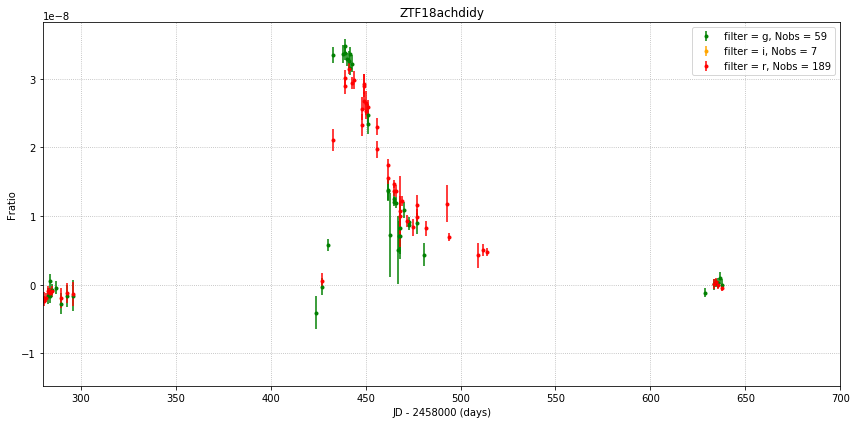

In [38]:
plot_fil(baseline2, name, targetdir, 280, 700)

## 5. Combine all data

In [39]:
baseline2 = calculate_mag(baseline2)

/data/deepnika/Coadding/reconstruct_data.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['mag'][neg] = [99 for i in range (mtb[neg].shape[0])]
/data/deepnika/Coadding/reconstruct_data.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['emag'][neg] = [99 for i in range (mtb[neg].shape[0])]
/data/deepnika/Coadding/reconstruct_data.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mtb['limmag'][neg] = -2.5 * np.log10(5*efratio[neg].values)
/data/deepnika/Coadding/reco

In [40]:
baseline2

,jdobs,filter,mag,emag,limmag,Fratio,Fratio_unc,upperlim,programid,instrument,source,refsys,issub,isdiffpos,SNR,coa
0,2.458077e+06,r,99.000000,99.000000,20.920577,-1.007596e-09,8.566413e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.176217,0.0
1,2.458079e+06,r,99.000000,99.000000,20.828551,-1.624339e-09,9.324159e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.742076,0.0
2,2.458089e+06,r,99.000000,99.000000,21.031487,-1.041439e-09,7.734554e-10,True,0.0,P48+ZTF,IPAC,None,True,False,-1.346475,0.0
3,2.458091e+06,r,99.000000,99.000000,19.525364,-3.662616e-10,3.096596e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.118279,0.0
4,2.458091e+06,r,99.000000,99.000000,19.409849,-2.712002e-11,3.444216e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.007874,0.0
5,2.458091e+06,r,99.000000,99.000000,19.520571,-3.352206e-09,3.110294e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-1.077778,0.0
6,2.458092e+06,r,99.000000,99.000000,20.530169,-2.300303e-09,1.227333e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-1.874228,0.0
7,2.458092e+06,r,99.000000,99.000000,20.486164,-2.954341e-09,1.278099e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-2.311512,0.0
8,2.458092e+06,r,99.000000,99.000000,20.256356,-5.102885e-10,1.579383e-09,True,0.0,P48+ZTF,IPAC,None,True,True,-0.323093,0.0
9,2.458093e+06,r,99.000000,99.000000,19.580171,-2.191905e-09,2.944160e-09,True,0.0,P48+ZTF,IPAC,None,True,False,-0.744493,0.0


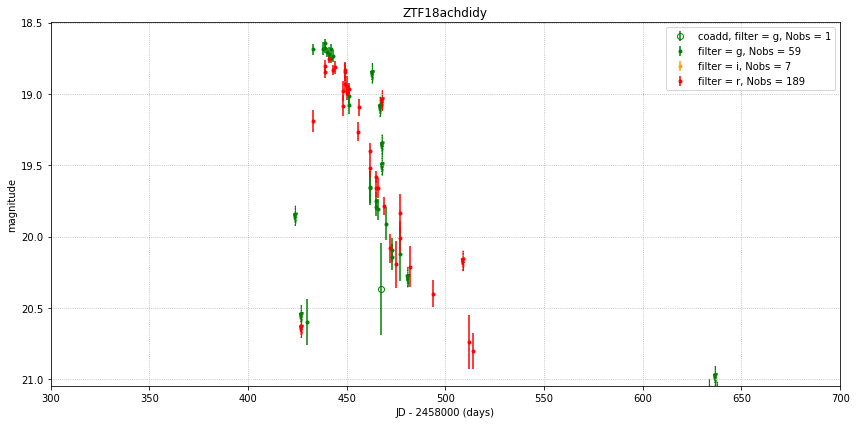

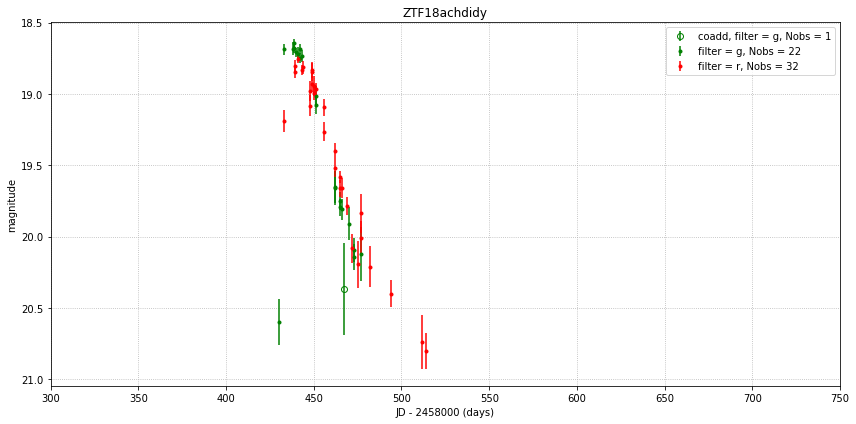

In [41]:
f = baseline2['SNR'] >3
plot_mag(baseline2, name, targetdir, 300, 700)
plot_mag(baseline2[f], name, targetdir, 300, 750)

In [44]:
marshal['programid'].unique()

array([1., 2., 4.])

In [45]:
marshal

,date,jdobs,filter,seeing,absmag,mag,emag,limmag,Fmcmc,Fmcmc_unc,...,upperlim,programid,instrument,source,refsys,issub,isdiffpos,offset,f0,ef0
0,2018 Nov 10,2.458433e+06,g,0.0,-20.32,18.65,0.09,20.39,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
1,2018 Nov 10,2.458433e+06,r,0.0,-19.83,19.14,0.17,19.72,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
2,2018 Nov 16,2.458439e+06,g,0.0,-20.33,18.64,0.07,20.65,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
3,2018 Nov 16,2.458439e+06,r,0.0,-20.21,18.75,0.09,20.02,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
4,2018 Nov 19,2.458442e+06,g,0.0,-20.23,18.74,0.08,20.58,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
5,2018 Nov 25,2.458448e+06,r,0.0,-19.94,19.03,0.13,19.66,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
6,2018 Nov 26,2.458449e+06,r,0.0,-20.11,18.86,0.12,19.52,0.0,0.0,...,False,2.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
7,2018 Nov 27,2.458450e+06,r,0.0,-20.03,18.94,0.11,19.60,0.0,0.0,...,False,2.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
8,2018 Nov 28,2.458451e+06,g,0.0,-19.99,18.98,0.10,19.87,0.0,0.0,...,False,1.0,P48+ZTF,Marshal,None,True,True,0.0,0.0,0.0
9,2018 Dec 04,2.458457e+06,r,0.0,-19.74,19.23,0.11,99.00,0.0,0.0,...,False,4.0,P60+SEDM,Marshal,SDSS,True,True,0.0,0.0,0.0


In [46]:
def combine_all_data(marshal, baseline2):
    marshal_other =np.any([marshal['programid'] == 4, marshal['programid'] == 36], axis = 0) 
    marshal1 = marshal[marshal_other]
    marshal1 = marshal1.drop(marshal1.iloc[:, [0, 3, 4, 8, 9, 12, 13, 14, 22]], axis = 1)

    n = marshal1.shape[0]
    SNR = np.zeros(n)
    marshal1.insert(14, 'SNR', SNR)
    coa = [False for i in range(n)]
    marshal1.insert(15, 'coa', coa)
    marshal1['upperlim'] = [False for i in range(n)]
    qs = marshal1['mag'] == 99
    marshal1['upperlim'][qs] = [True for i in range(marshal1[qs].shape[0])]
    marshal1
    combined = pd.concat([baseline2, marshal1])
    
    return combined



combined = combine_all_data(marshal, baseline2)

/data/deepnika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/data/deepnika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [47]:
combined.to_csv(targetdir + 'data/results_' + name + '.csv', index = False, encoding = 'utf8')

## 6. Plot final data

###### Checkpoint

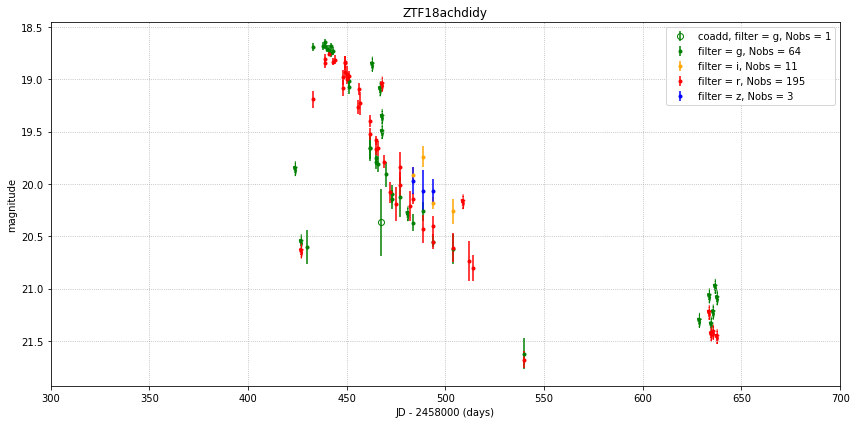

In [48]:
f = combined['SNR'] > 5
plot_mag(combined, name, targetdir, 300, 700)

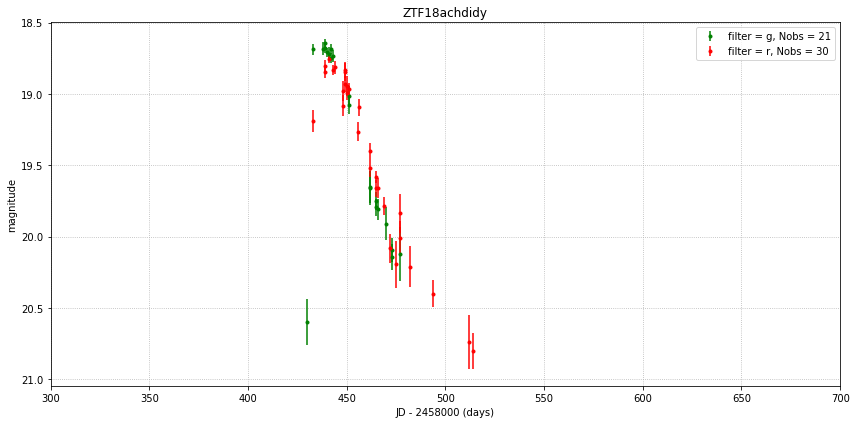

In [49]:
plot_mag(combined[f], name, targetdir, 300, 700)